<a href="https://colab.research.google.com/github/Vicss0529/collab-notebook/blob/main/ResNet_Layers_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import and prepare the dataset.
# https://github.com/m-peker/ResNet-Layers-Visualization/tree/master

from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
import numpy as np
import os

# Training parameters
batch_size = 32
epochs = 100
data_augmentation = True

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

if K.image_data_format() == 'channels_first':
    img_rows = x_train.shape[2]
    img_cols = x_train.shape[3]
    channels = x_train.shape[1]
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    img_rows = x_train.shape[1]
    img_cols = x_train.shape[2]
    channels = x_train.shape[3]
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

print(f"tensorflow version: {tf.__version__}")

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

tensorflow version: 2.15.0
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [2]:
#@title Resnet Bottleneck
# Start model definition.
inputs = Input(shape=input_shape)
x = Conv2D(num_filters,
           kernel_size=7,
           padding='same',
           strides=2,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

if use_max_pool:
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    num_blocks = 3

# Building the basis of the model
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate model.
model_bottleneck = Model(inputs=inputs, outputs=outputs)
model_bottleneck.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model_bottleneck.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

In [2]:
#@title Resnet Preactivation
# Start model definition.
inputs = Input(shape=input_shape)
x = Conv2D(num_filters,
           kernel_size=7,
           padding='same',
           strides=2,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

if use_max_pool:
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    num_blocks = 3

# Building the basis of the model
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate model.
model_preactivation = Model(inputs=inputs, outputs=outputs)
model_preactivation.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model_preactivation.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

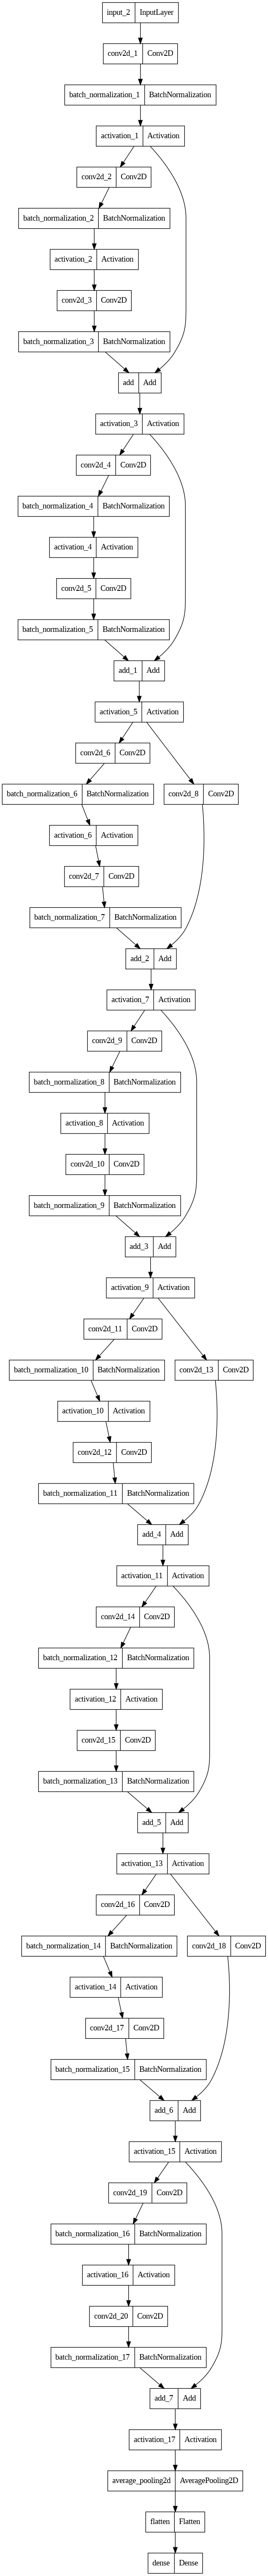

In [11]:
plot_model(model_preactivation)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_validation.shape)

# history = model.fit(X_train,
#                     y_train,
#                     epochs=10,
#                     validation_data=(X_validation, y_validation)
#                     )

(40000, 32, 32, 3) (10000, 32, 32, 3)


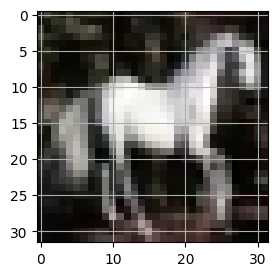

In [4]:
# Layer visualization on the test image

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

n=13
img = x_test[n]

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img)
ax.grid(True)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [5]:
from keras.models import Model
layer_outputs = [layer.output for layer in model_preactivation.layers if not layer.name.startswith('input')]
activation_model = Model(inputs=model_preactivation.input, outputs=layer_outputs)
activation_model

In [6]:
activations = activation_model.predict(x)

1/1 [==============================] - 3s 3s/step


In [7]:
# first conv layer activation
first_conv_activation = activations[1]
print(first_conv_activation.shape)

(1, 16, 16, 64)


In [8]:
def plot_activations(layer_idx, activations):
    layer_activation = activations[layer_idx][0]
    n_row = 8
    n_column = layer_activation.shape[-1]//n_row

    f, ax = plt.subplots(n_row, n_column, figsize=(4,4))
    for i in range(n_row):
        for j in range(n_column):
            channel_image = layer_activation[:, :, i*n_column+j]
            # image post-processing for better visualization
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            ax[i, j].imshow(channel_image, cmap='viridis')
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    f.set_size_inches(n_column, n_row)
    plt.show()

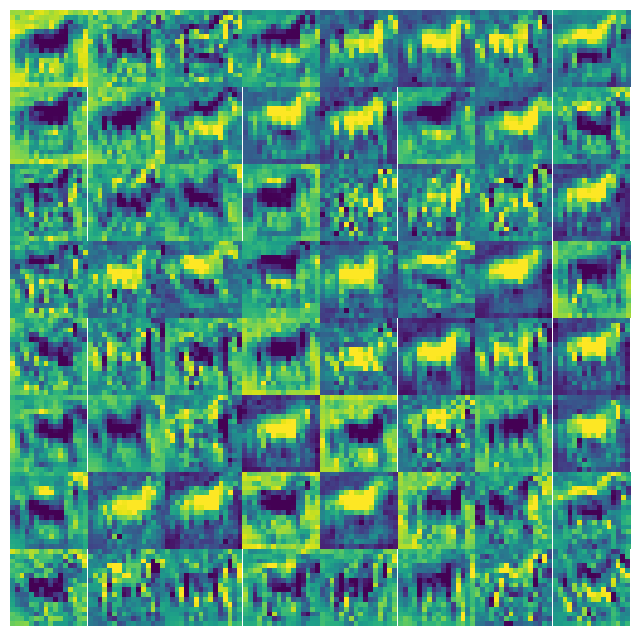

In [9]:
plot_activations(1, activations)

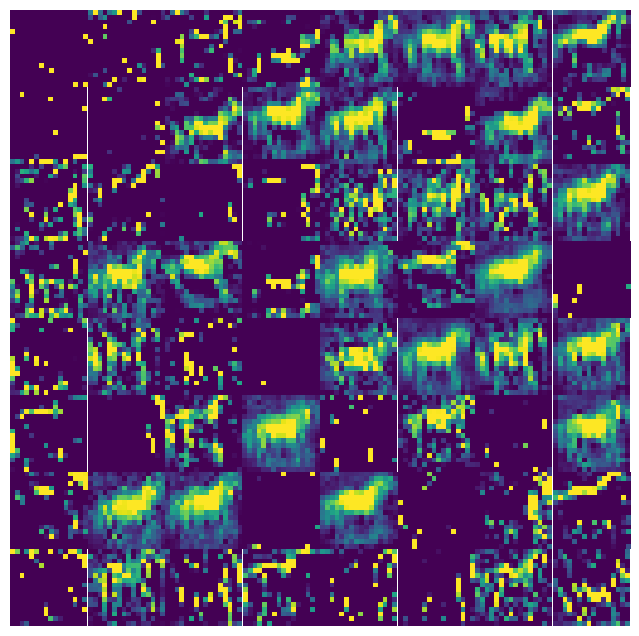

In [10]:
plot_activations(2, activations)

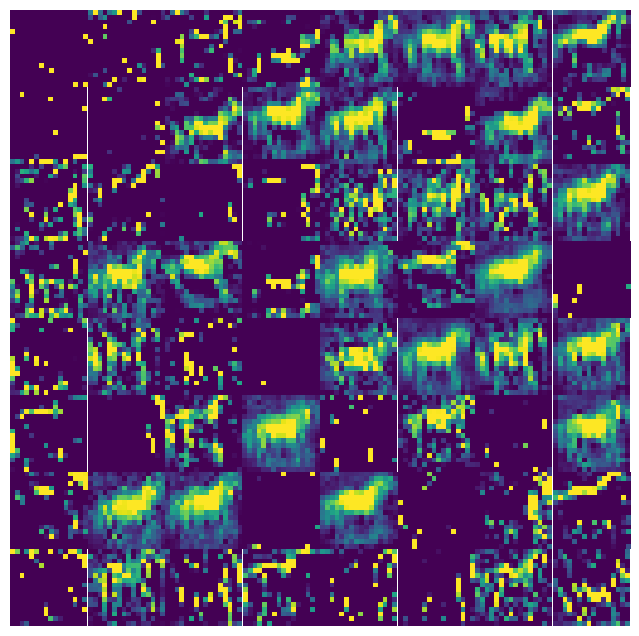

In [11]:
plot_activations(3, activations)

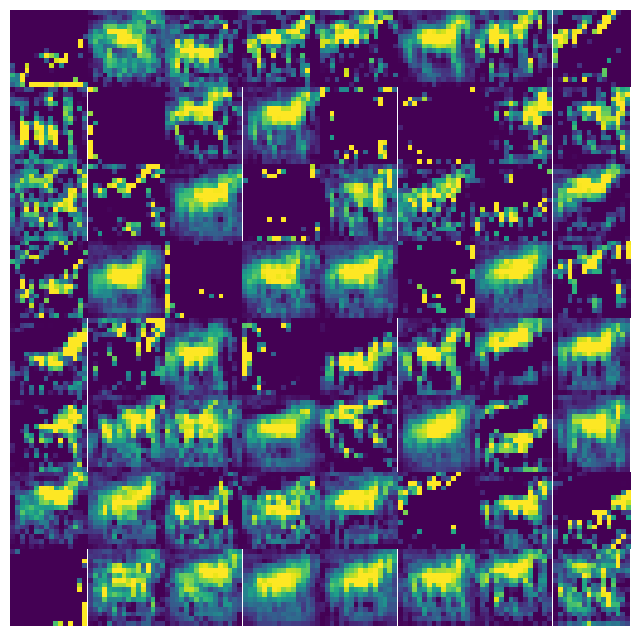

In [12]:
plot_activations(10, activations)

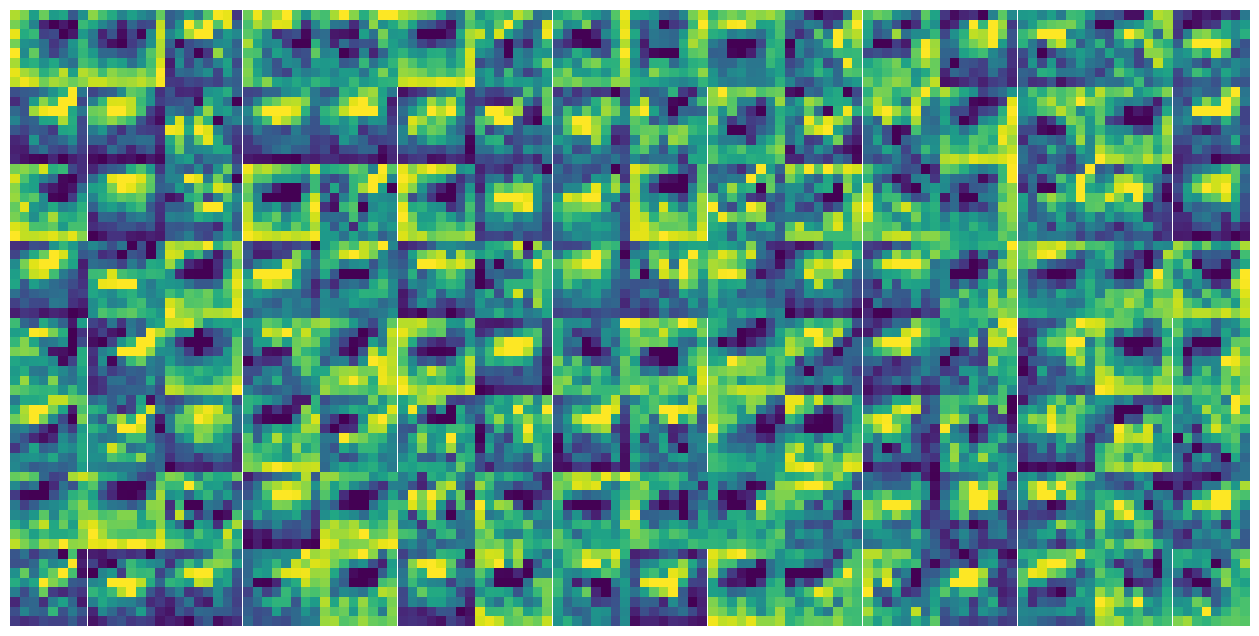

In [13]:
plot_activations(20, activations)

In [ ]:
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [ ]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });